Status	Public on Aug 08, 2019
Title	Single-cell RNA-seq of frequent and rare populations in mouse bone marrow
Organism	Mus musculus
Experiment type	Expression profiling by high throughput sequencing
Summary	This data set contains single-cell RNA sequencing data of mature immune cells, hematopoietic and immune progenitors, mesenchymal cells (CAR cells, fibroblasts, osteoblasts, chondrocytes, putative mesenchymal stem cells), endothelia, smooth muscle, and Schwann cells.
 	
Overall design	The following fractions were subjected to single-cell RNA-sequencing using 10x genomics: Total live bone marrow; Lineage-negative CD45-negative bone marrow; Lineage-CD45-CD71- bone marrow (obtained by crushing or flushing of bones); Lineage-CD45-CD71- bone-associated fraction (obtained by digesting bone chips); Lineage-Kit+ bone marrow.

In [31]:
import pandas as pd
import anndata as ad
import scanpy as sc

In [32]:
counts = pd.read_csv("/home/roger/project_LYPI/data/GSE122465_FilteredCounts10x.csv.gz", compression="gzip", index_col=0).T
metadata = pd.read_csv("/home/roger/project_LYPI/data/metadata.csv", index_col=0)

In [33]:
adata = ad.AnnData(X=counts)
adata.obs_names = counts.index
adata.var_names = counts.columns
adata.obs = adata.obs.join(metadata, how='left')

In [34]:
# Basic pre-processing steps
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1)

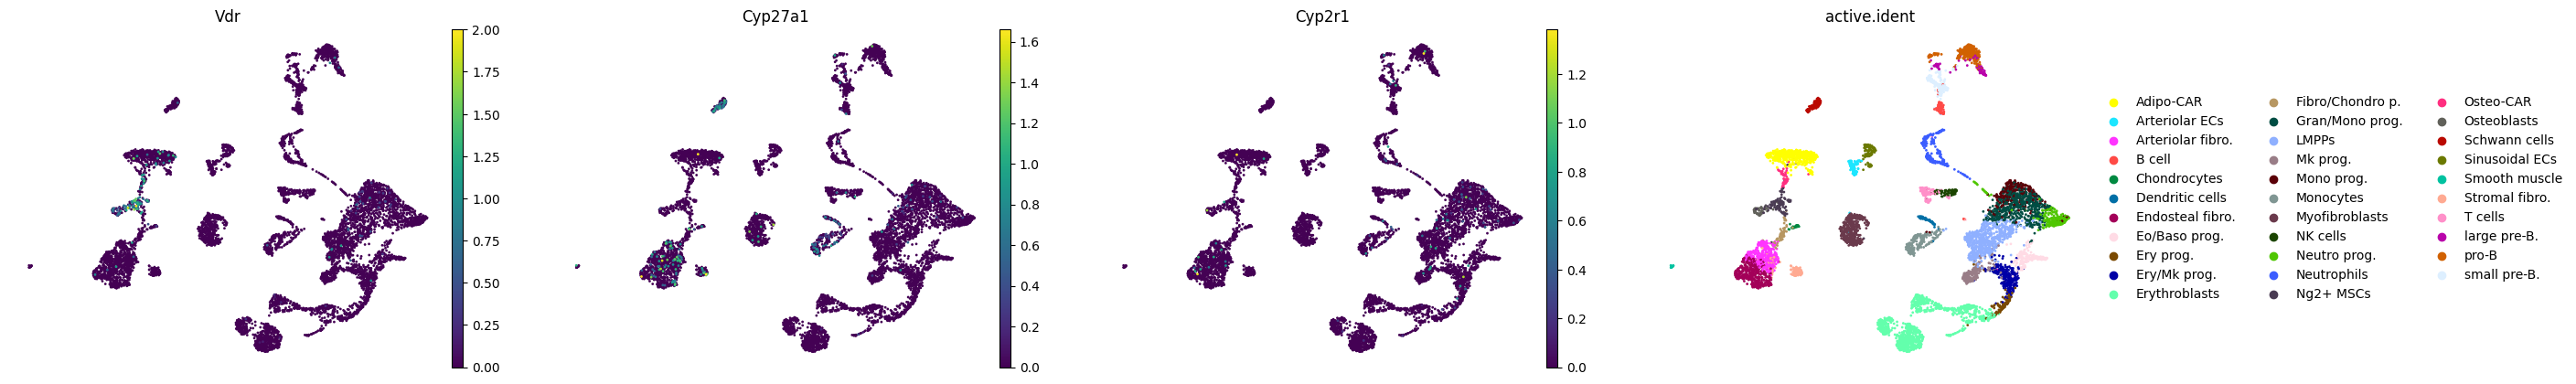

In [35]:
sc.pl.umap(adata, color=["Vdr", "Cyp27a1",  "Cyp2r1", "active.ident"], frameon=False, ncols=5)

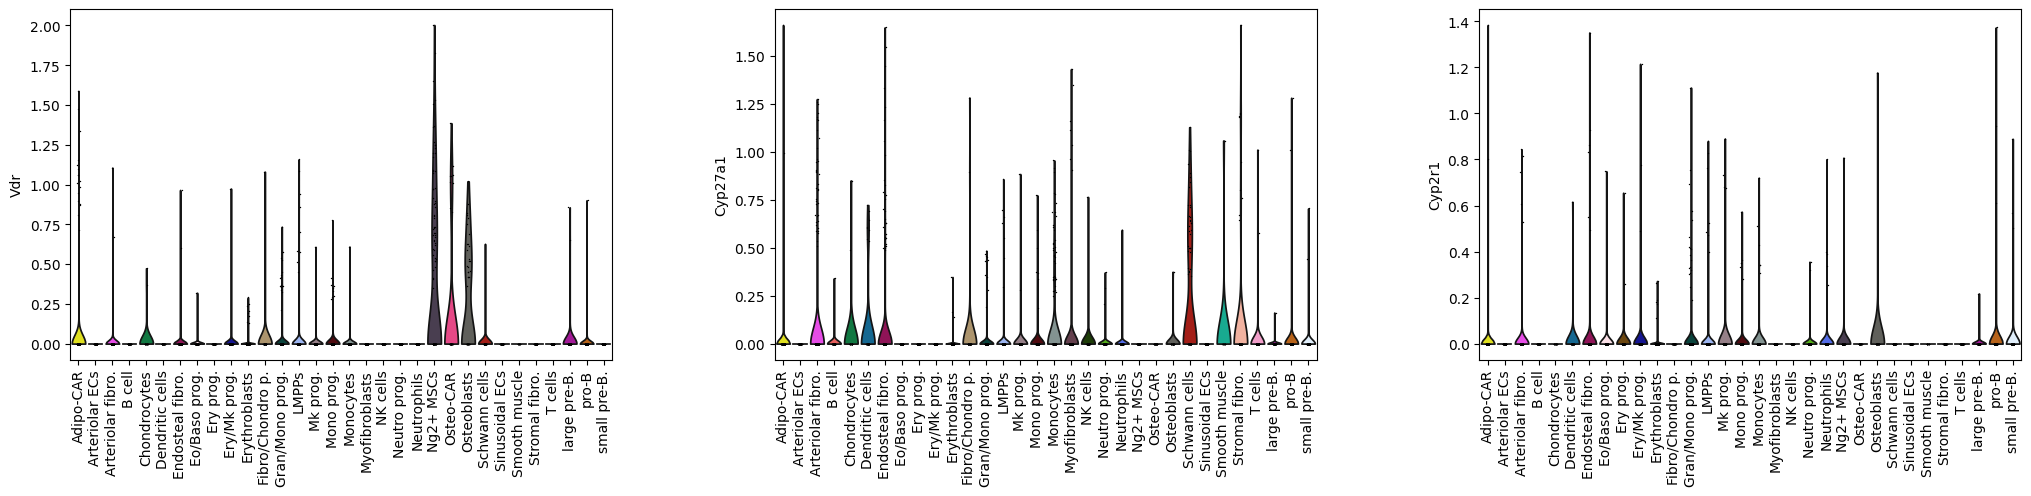

In [36]:
adata.var_names_make_unique()
sc.pl.violin(adata, keys=["Vdr", "Cyp27a1", "Cyp2r1"], groupby="active.ident", rotation=90)  #  "Cyp27b1" there's no cyb27b1

In [37]:
sc.tl.rank_genes_groups(adata, groupby="active.ident", method="wilcoxon")

/home/roger/anaconda3/envs/celloracle_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/roger/anaconda3/envs/celloracle_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/roger/anaconda3/envs/celloracle_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_g

In [38]:
#sampling
# Genes to check
genes_to_check = ["Vdr", "Cyp27a1", "Cyp27b1", "Cyp2r1"]

# Extract the DE results
rank_genes_groups = adata.uns["rank_genes_groups"]

# Initialize a dictionary to store the results
significant_genes = {}

# Check each gene in the results
for gene in genes_to_check:
    significant_genes[gene] = {}
    for group in rank_genes_groups['pvals_adj'].dtype.names:
        # Check if the gene is in the names for the current group
        if gene in rank_genes_groups['names'][group]:
            # Get the index of the gene in the names array
            gene_index = list(rank_genes_groups['names'][group]).index(gene)
            # Get the corresponding p-value
            pval = rank_genes_groups['pvals_adj'][group][gene_index]
            # Check if the p-value is below the threshold
            if pval < 0.05:
                significant_genes[gene][group] = pval

# Display the results
for gene, groups in significant_genes.items():
    if groups:
        print(f"{gene} is significant in the following groups (p < 0.05):")
        for group, pval in groups.items():
            print(f"  - {group}: p-value = {pval}")
    else:
        print(f"{gene} is not significant in any group (p < 0.05).")
# 

Vdr is significant in the following groups (p < 0.05):
  - Ng2+ MSCs: p-value = 4.6347941576892735e-14
  - Osteoblasts: p-value = 8.96082990618555e-06
Cyp27a1 is significant in the following groups (p < 0.05):
  - Arteriolar fibro.: p-value = 0.04479550624142121
  - Monocytes: p-value = 0.0011856468113001868
  - Schwann cells: p-value = 3.1465923348609946e-07
Cyp27b1 is not significant in any group (p < 0.05).
Cyp2r1 is not significant in any group (p < 0.05).


###DO A PLOT WITH THE LOG2FC VALUES PROBABLY? OR SOMETHING LIKE THAT, WITH THE CELL TYPES OF INTEREST!

In [39]:
import decoupler as dc
net = dc.get_collectri(organism='human', split_complexes=False)
new_adata = adata
new_adata.var_names = new_adata.var_names.str.upper()
dc.run_ulm(
    mat=new_adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)
new_adata.obsm['collectri_ulm_estimate'] = new_adata.obsm['ulm_estimate'].copy()
new_adata.obsm['collectri_ulm_pvals'] = new_adata.obsm['ulm_pvals'].copy()
acts = dc.get_acts(new_adata, obsm_key='ulm_estimate')

Running ulm on mat with 7497 samples and 16701 targets for 705 sources.


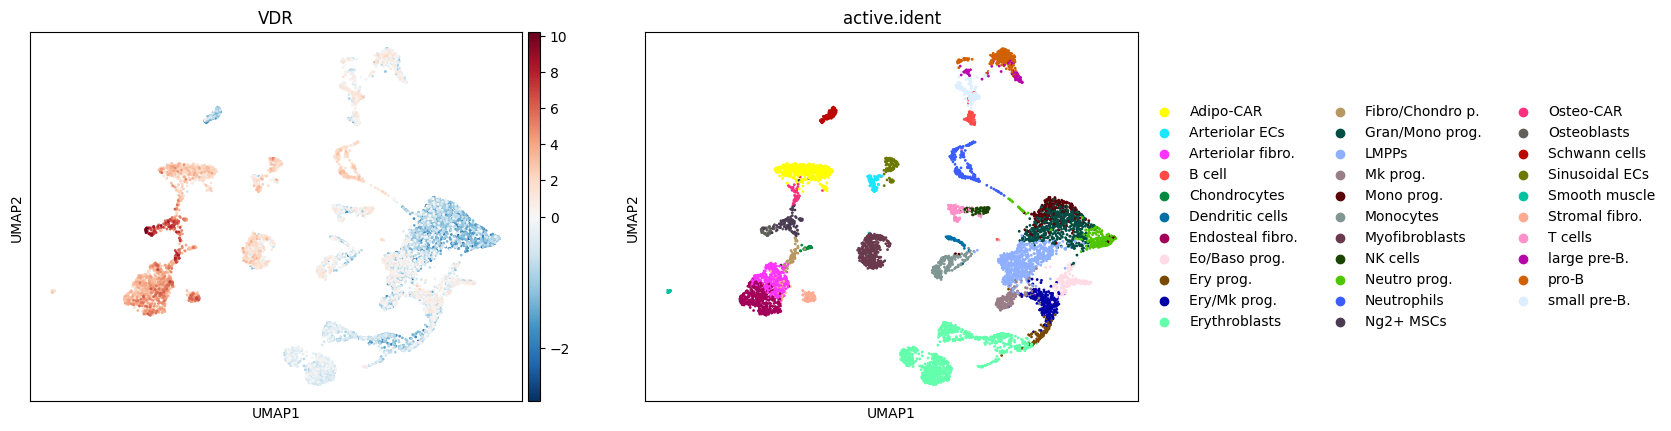

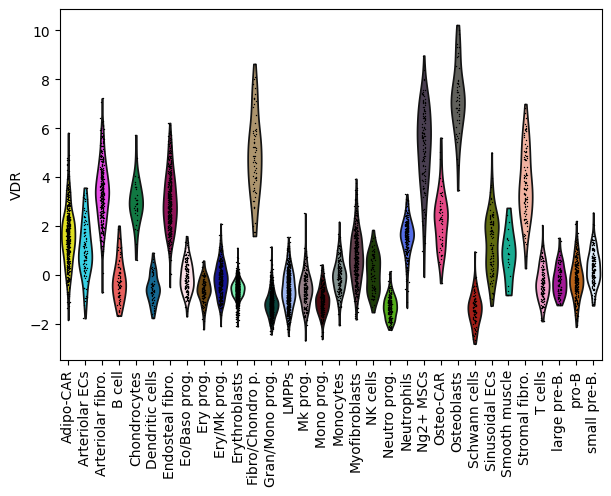

In [40]:
sc.pl.umap(acts, color=['VDR', 'active.ident'], cmap='RdBu_r', vcenter=0)
sc.pl.violin(acts, keys=['VDR'], groupby='active.ident', rotation=90)